In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import os
import pickle
import sys
from IPython.display import clear_output
sys.path.append("..")
from tqdm import tqdm
import networkx as nx

In [2]:
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, log_loss
from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import TheilSenRegressor
from copy import deepcopy      
from collections import Counter

EPS = 1e-6

## Чтение данных

In [2]:
import pandas as pd
from tqdm import tqdm_notebook

def digraph_to_csv(graphs: list):
    df = pd.DataFrame(columns=['brick_id', 'shower_id', 'SX', 'SY', 'SZ', 'TX', 'TY'])
    for i, graph in tqdm_notebook(enumerate(graphs)):
        nodes = graph.nodes()
        SX = [node['features']['SX'] for node in nodes.values()]
        SY = [node['features']['SY'] for node in nodes.values()]
        SZ = [node['features']['SZ'] for node in nodes.values()]
        TX = [node['features']['TX'] for node in nodes.values()]
        TY = [node['features']['TY'] for node in nodes.values()]
        shower_id = [node['signal'] for node in nodes.values()]
        brick_id = [i for _ in range(len(shower_id))]
        df = df.append(
            pd.DataFrame(
                {'brick_id': brick_id, 
                 'shower_id': shower_id, 
                 'SX': SX, 
                 'SY': SY, 
                 'SZ': SZ, 
                 'TX': TX, 
                 'TY': TY
                }
            )
        )
    return df
        

def csv_to_digraph(df: pd.DataFrame):
    bricks = []
    for name, group in df.groupby('brick_id'):
        print(group.shape)
        nodes_to_add = []

        for node_id, row in group.iterrows():
            nodes_to_add.append(
                (
                    node_id,
                    {
                        'features': {
                            'SX': row.SX,
                            'SY': row.SY,
                            'SZ': row.SZ,
                            'TX': row.TX,
                            'TY': row.TY,
                        },
                        'signal': row['shower_id']
                    }
                )
            )
        graphx = nx.DiGraph()
        graphx.add_nodes_from(nodes_to_add)
        bricks.append(graphx)
    return bricks

In [3]:
df = np.loadtxt('./data/opera_train.data')
df = pd.DataFrame(df, columns=['brick_id', 'SX', 'SY', 'SZ', 'TX', 'TY'])

In [4]:
df.head()

,brick_id,SX,SY,SZ,TX,TY
0,0.0,-10177.71,-8697.63,-24330.69,-0.1505,0.1620
1,0.0,-10375.19,-8490.78,-23056.31,-0.1585,0.1673
2,0.0,-10591.61,-8268.13,-21785.49,-0.1913,0.1805
3,0.0,-10827.50,-8042.95,-20510.45,-0.1643,0.2017
4,0.0,-11053.21,-7800.50,-19239.20,-0.2127,0.1621


In [5]:
df.shape

(3000038, 6)

In [6]:
df.brick_id.nunique()

230

In [7]:
BRICK_X_MIN = 0.
BRICK_X_MAX = 103000. # 10.3 cm
BRICK_Y_MIN = 0.
BRICK_Y_MAX = 128000. # 12.8 cm
SAFE_M = 3000.
dZ = 205. # 0.0205 cm emulsion
DISTANCE = 1293.

def plot_dataframe(data: pd.DataFrame, azim=-84, elev=10):
    """
    Function for plotting shower
    """
    from mpl_toolkits.mplot3d import Axes3D
    from mpl_toolkits.mplot3d.art3d import Line3DCollection
    import matplotlib.pyplot as plt
    x0, y0, z0 = data.SX.values, data.SY.values, data.SZ.values
    sx, sy = data.TX.values, data.TY.values

    x1 = x0 + dZ * sx
    y1 = y0 + dZ * sy
    z1 = z0 + dZ
    
    start_points = np.array([z0, y0, x0]).T.reshape(-1, 3)
    end_points = np.array([z1, y1, x1]).T.reshape(-1, 3)

    C = plt.cm.Blues(0.9)
    lc = Line3DCollection(list(zip(start_points, end_points)), colors=C, alpha=0.9, lw=2)

    fig = plt.figure(figsize=(12, 12))
    ax = fig.gca(projection='3d')
    ax.view_init(azim=azim, elev=elev)
    ax.add_collection3d(lc)
    
    ax.set_xlabel("z")
    ax.set_ylabel("y")
    ax.set_zlabel("x") 
    ax.set_xlim(z0.min(), z1.max())
    ax.set_ylim(y0.min(), y1.max())
    ax.set_zlim(x0.min(), x1.max())
    
    plt.show()


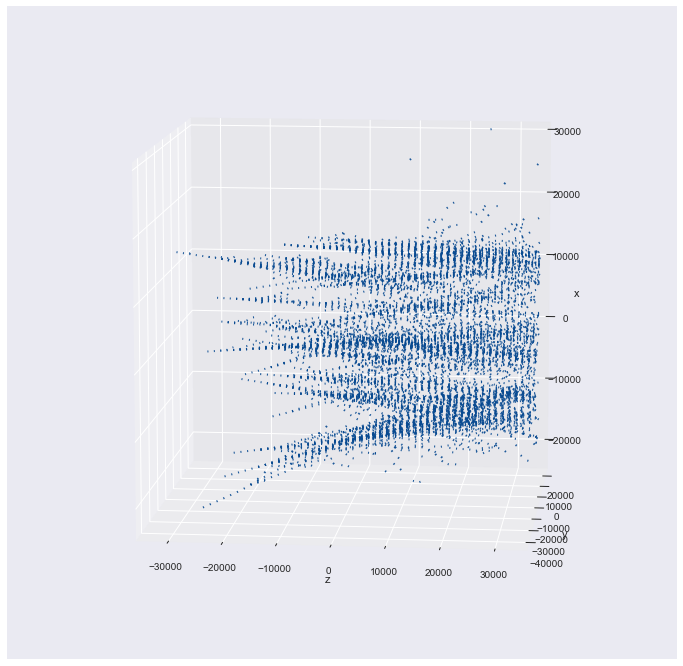

In [8]:
# будьте осторжны! Не подавайте на вход весь датафрейм
plot_dataframe(df.loc[df.brick_id==1])

In [9]:
df_labels = np.loadtxt('./data/opera_train.solution')
df_labels = pd.DataFrame(df_labels, columns=['brick_id', 'shower_id'])

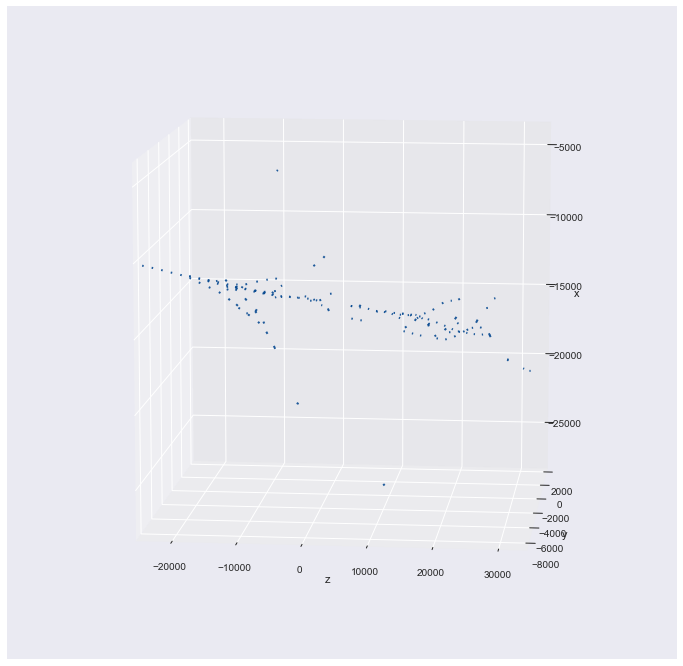

In [10]:
plot_dataframe(df.loc[(df_labels.brick_id==0) & (df_labels.shower_id==0)])

In [11]:
df['shower_id'] = df_labels.shower_id

In [12]:
df.loc[df.brick_id==1].head()

,brick_id,SX,SY,SZ,TX,TY,shower_id
10628,1.0,1140.23,-9186.12,-15419.87,-0.0532,-0.0118,0.0
10629,1.0,1073.92,-9200.10,-14147.28,-0.0536,-0.0110,0.0
10630,1.0,1005.61,-9214.20,-12874.51,-0.0566,-0.0134,0.0
10631,1.0,938.33,-9230.06,-11601.14,-0.0528,-0.0128,0.0
10632,1.0,873.79,-9246.86,-10328.24,-0.0485,-0.0146,0.0


In [13]:
df.loc[df.brick_id==1]['shower_id'].nunique()

27

In [14]:
bricks = csv_to_digraph(df.loc[(df_labels.brick_id==0)])

(10628, 7)


In [29]:
bricks = csv_to_digraph(df.loc[(df_labels.brick_id==0) & (df_labels.shower_id==0)])

(152, 7)
